<a href="https://colab.research.google.com/github/SoroushVahidi/A-new-approach-for-Image-resize-implemented-in-matlab/blob/master/heterophilic_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install gurobipy
!pip install torch_geometric
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import torch
from torch_geometric.datasets import Planetoid
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import pairwise_distances as sklearn_pairwise_distances
import networkx as nx
 # Use "cosine" for cosine similarity
import heapq
from torch_geometric.datasets import WebKB

os.environ["GRB_LICENSE_FILE"] = "gurobi (3).lic"
os.environ["GRB_WLSACCESSID"] = "f218200d-1f8d-4342-83f5-b7b2d9263751"  # Replace with your actual WLSACCESSID
os.environ["GRB_WLSSECRET"] = "528d596b-babc-4a1e-bda2-693c44f4f006"  # Replace with your actual WLSSECRET
os.environ["GRB_LICENSEID"] = "840285"  # Replace with your actual LICENSEID

!pip install gurobipy torch_geometric
from collections import Counter


✅ Using Twitch dataset: 9498 nodes, 315774 edges
✅ Using 2000 nodes: 1200 train, 400 validation, 400 test

📊 Degree Distribution in Subset (Percentage):
  - 18.75% of nodes have degree 1
  - 15.15% of nodes have degree 2
  - 12.45% of nodes have degree 3
  - 8.40% of nodes have degree 4
  - 7.15% of nodes have degree 5
  - 6.65% of nodes have degree 6
  - 4.20% of nodes have degree 7
  - 3.70% of nodes have degree 8
  - 2.75% of nodes have degree 9
  - 2.50% of nodes have degree 10
  - 1.70% of nodes have degree 11
  - 1.80% of nodes have degree 12
  - 1.20% of nodes have degree 13
  - 1.80% of nodes have degree 14
  - 1.15% of nodes have degree 15
  - 0.85% of nodes have degree 16
  - 1.10% of nodes have degree 17
  - 1.00% of nodes have degree 18
  - 0.70% of nodes have degree 19
  - 0.50% of nodes have degree 20
  - 0.55% of nodes have degree 21
  - 0.70% of nodes have degree 22
  - 0.15% of nodes have degree 23
  - 0.55% of nodes have degree 24
  - 0.25% of nodes have degree 25
  -

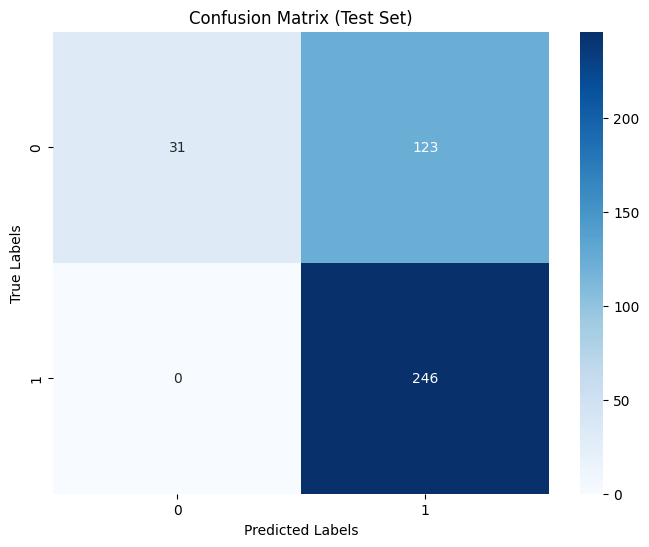

<ipython-input-28-3f0e518ae071>:205: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))  # Use colormap for up to 10 classes


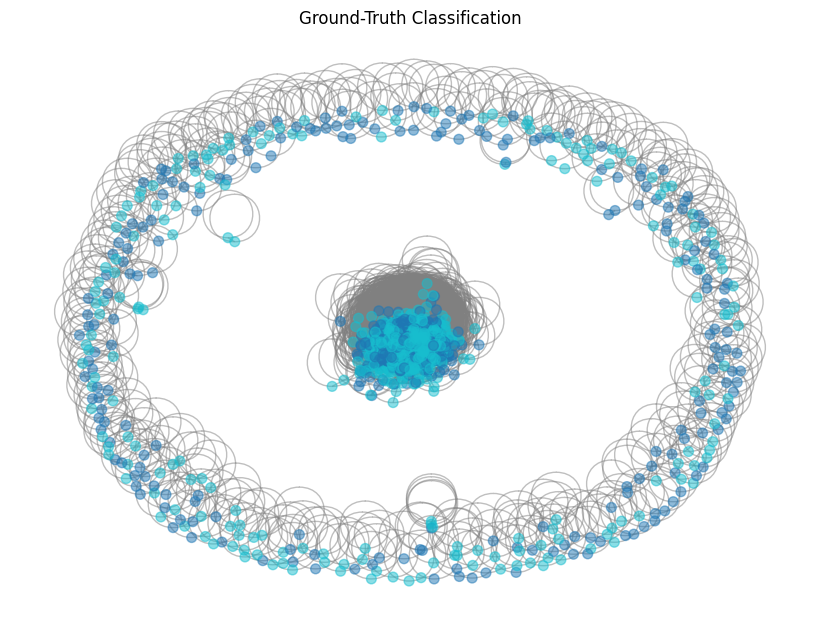

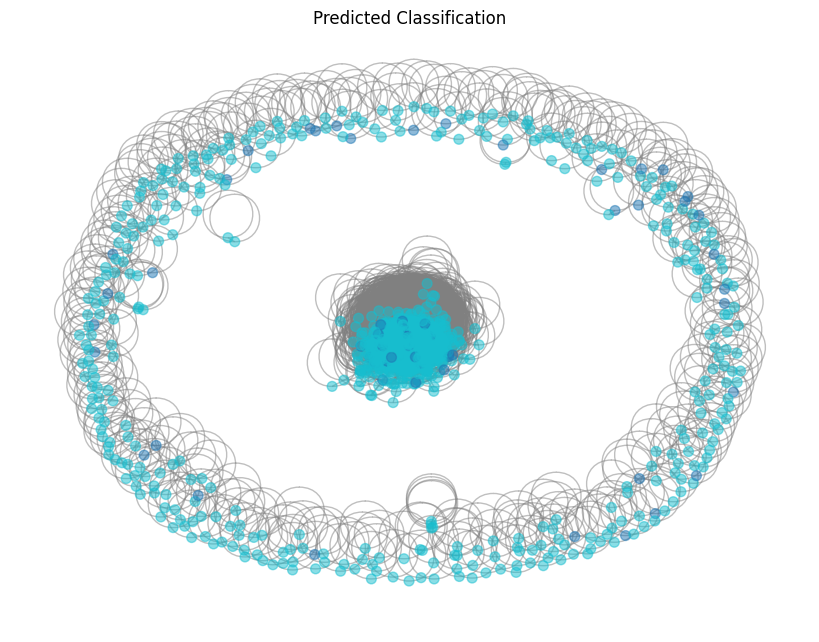

In [28]:
from torch_geometric.datasets import Twitch

dataset = Twitch(root='data', name='DE')  # Options: "DE", "EN", "ES", "FR", etc.
data = dataset[0]

A = torch.zeros((data.num_nodes, data.num_nodes))
A[data.edge_index[0], data.edge_index[1]] = 1
A = A.numpy()

X = data.x.numpy()
labels = data.y.numpy()

print(f"✅ Using Twitch dataset: {data.num_nodes} nodes, {data.edge_index.shape[1]} edges")


# 📌 STEP 2: SPLIT DATA INTO TRAIN, VALIDATION, AND TEST
subset_size = 2000  # Select a smaller subset for efficiency
selected_indices = np.random.choice(data.num_nodes, subset_size, replace=False)

# Define split sizes
subset_train_size = int(0.6 * subset_size)
subset_val_size = int(0.2 * subset_size)
subset_test_size = subset_size - subset_train_size - subset_val_size

# ✅ Properly split selected indices into train, val, test
train_indices = selected_indices[:subset_train_size]
val_indices = selected_indices[subset_train_size:subset_train_size + subset_val_size]
test_indices = selected_indices[subset_train_size + subset_val_size:]

# ✅ Ensure we correctly sample train nodes per class
train_size_per_class = subset_train_size // m  # Divide by the number of classes
train_indices = []
for c in np.unique(labels):
    class_indices = np.where(labels == c)[0]
    selected = np.random.choice(class_indices, min(train_size_per_class, len(class_indices)), replace=False)
    train_indices.extend(selected)
train_indices = np.array(train_indices)

# Extract subset from adjacency matrix and features
A_subset = A[selected_indices][:, selected_indices]
X_subset = X[selected_indices]
labels_subset = labels[selected_indices]

# ✅ Correctly map train and validation labels
train_labels = {
    i: labels_subset[idx[0]] for i in train_indices if (idx := np.where(selected_indices == i)[0]).size > 0
}
val_labels = {
    i: labels_subset[idx[0]] for i in val_indices if (idx := np.where(selected_indices == i)[0]).size > 0
}


print(f"✅ Using {subset_size} nodes: {subset_train_size} train, {subset_val_size} validation, {subset_test_size} test")
def count_degrees(A_subset):
    """Counts the percentage of nodes with each degree in the subset."""
    degrees = np.sum(A_subset, axis=1)  # Compute degree of each node
    degree_counts = Counter(degrees)  # Count occurrences of each degree
    total_nodes = len(degrees)  # Total number of nodes in subset

    print("\n📊 Degree Distribution in Subset (Percentage):")
    for degree, count in sorted(degree_counts.items()):
        percentage = (count / total_nodes) * 100
        print(f"  - {percentage:.2f}% of nodes have degree {int(degree)}")

    return degree_counts

# ✅ Run degree counting function
degree_counts = count_degrees(A_subset)
print(degree_counts)  #

def build_base_lp_model(A, X, labels, train_indices, m):
    """Builds the base LP model with constraints that do not depend on f."""
    n, d = X.shape
    print(f"🚀 Building base LP model for {n} nodes and {d} features...")

    pairwise_distances = sklearn_pairwise_distances(X, metric="cosine")

    # ✅ Construct adjacency list to speed up constraint updates
    adj_list = {i: np.where(A[i] > 0)[0].tolist() for i in range(n)}
    degrees = np.array([len(adj_list[i]) for i in range(n)])  # Compute degree for each node

    # ✅ Initialize Gurobi model
    model = gp.Model("Graph_Coloring_LP")

    # ✅ Decision variables (Continuous Relaxation)
    X_var = model.addVars(n, m, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="X")
    Y_var = model.addVars(n, n, m, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="Y")

    print("✅ Adding basic constraints...")

    # ✅ Each node must be assigned exactly one class
    for i in range(n):
        model.addConstr(gp.quicksum(X_var[i, j] for j in range(m)) == 1)

    # ✅ Each class must be assigned to exactly one node
   # for j in range(m):
   #     model.addConstr(gp.quicksum(X_var[i, j] for i in range(n)) == 1)

    # ✅ Ensure train_indices are properly mapped within selected_indices
    train_indices_mapped = [np.where(selected_indices == i)[0] for i in train_indices]
    train_indices_mapped = [idx[0] for idx in train_indices_mapped if len(idx) > 0]  # Only valid indices

    # ✅ Enforce known labels
    for idx in train_indices_mapped:
        if labels_subset[idx] >= 0:  # Ensure label is valid
            model.addConstr(X_var[idx, labels_subset[idx]] == 1)

    print("✅ Base LP model created with adjacency list.")

    return model, X_var, Y_var, degrees, pairwise_distances, adj_list




def solve_relaxed_lp_reusable(model, X_var, Y_var, degrees, adj_list, n, m, f, pairwise_distances):
    """Finds the top 5 lowest-cost feasible solutions for a given f and records their objective values."""
    print(f"\n🔄 Updating model for f = {f:.1f}...")

    # ✅ Remove only constraints related to f
    model.remove(model.getConstrs())

    # ✅ Ensure each node is assigned to exactly one class
    for i in range(n):
        model.addConstr(gp.quicksum(X_var[i, j] for j in range(m)) == 1)

    # ✅ Ensure **no more than f * degree(i) of neighbors belong to the same class**
    for i in range(n):
        if degrees[i] > 0:  # ✅ Avoid isolated nodes
            for j in range(m):
                model.addConstr(gp.quicksum(Y_var[i, v, j] for v in adj_list[i]) <= f * degrees[i])

    # ✅ Objective: Minimize Total Pairwise Distance
    model.setObjective(
        gp.quicksum(pairwise_distances[i, v] * Y_var[i, v, j] for i in range(n) for v in adj_list[i] for j in range(m))
        - 0.000001 * gp.quicksum(X_var[i, j] * j for i in range(n) for j in range(m)),  # Prevents bias toward class 0
        GRB.MINIMIZE
    )

    # ✅ Enable multiple solutions with relaxed diversity criteria
    model.setParam(GRB.Param.PoolSearchMode, 2)  # Find multiple near-optimal solutions
    model.setParam(GRB.Param.PoolSolutions, 10)  # Try storing up to 10 solutions
    model.setParam(GRB.Param.PoolGap, 0.05)      # Allow larger gap to encourage diverse solutions

    # ✅ Solve the model
    model.optimize()

    # ✅ Handle cases where no feasible solutions are found
    if model.status == GRB.INFEASIBLE or model.SolCount == 0:
        print(f"❌ No feasible solutions found for f = {f:.3f}. Returning empty list.")
        return [], []

    # ✅ Extract up to 5 best feasible solutions
    num_solutions = min(5, model.SolCount)
    solutions = []
    objective_values = []

    for sol_idx in range(num_solutions):
        model.setParam(GRB.Param.SolutionNumber, sol_idx)  # Select solution

        # ✅ Safe access to PoolObjVal or ObjVal
        if model.SolCount > 1:  # Multiple solutions exist
            obj_values = model.getAttr("PoolObjVal")
            obj_value = obj_values[sol_idx] if sol_idx < len(obj_values) else None
        else:  # Only one solution found
            obj_value = model.ObjVal

        objective_values.append(obj_value)

        assigned_labels = np.zeros(n, dtype=int)
        for i in range(n):
            max_j = -1
            max_val = -float('inf')
            for j in range(m):
                # ✅ Check if multiple solutions exist
                if model.SolCount > 1:
                    x_value = X_var[i, j].Xn
                else:
                    x_value = X_var[i, j].X

                if x_value > max_val:
                    max_j = j
                    max_val = x_value

            assigned_labels[i] = max_j  # Assign to the best j

        solutions.append(assigned_labels)

    # Print objective values for different solutions
    print(f"✅ Found {num_solutions} distinct feasible solutions for f = {f:.3f}!")
    for idx, obj_val in enumerate(objective_values):
        print(f"  - Solution {idx+1}: Objective Value = {obj_val if obj_val is not None else 'N/A'}")

    return solutions, objective_values




def plot_graph(A, labels, title):
    """Plots the graph with nodes colored by their labels."""
    G = nx.from_numpy_array(A)  # Create NetworkX graph from adjacency matrix
    pos = nx.spring_layout(G, seed=42)  # Use spring layout for consistency

    # Assign a unique color to each class
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap("tab10", len(unique_labels))  # Use colormap for up to 10 classes
    node_colors = [colors(int(label)) for label in labels]

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.5)
    plt.title(title)
    plt.show()

def plot_misclassified_graph(A, true_labels, pred_labels, title):
    """Plots a graph where misclassified nodes are red and correctly classified nodes are white."""
    G = nx.from_numpy_array(A)  # Create NetworkX graph from adjacency matrix
    pos = nx.spring_layout(G, seed=42)  # Use same layout for consistency

    node_colors = ['white' if true_labels[i] == pred_labels[i] else 'red' for i in range(len(true_labels))]

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.5)
    plt.title(title)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, f_value):
    """Plots confusion matrix as a heatmap with correct class labels."""
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))  # Ensure only valid labels are used
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=unique_classes, yticklabels=unique_classes)  # Set correct class labels
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix (Validation Set) for f={f_value:.1f}")
    plt.show()


def get_isolated_nodes_in_subset(A_subset):
    """Finds isolated nodes in the chosen subset (nodes with no neighbors in A_subset)."""
    degrees = np.sum(A_subset, axis=1)  # Sum rows to get degrees within the subset
    return set(np.where(degrees == 0)[0])  # Nodes with degree 0 in the subset

def get_degrees_in_subset(A_subset):
    """Computes the degree of each node in the subset based on A_subset."""
    return np.sum(A_subset, axis=1)  # Sum of connections for each node

import heapq
from sklearn.metrics import accuracy_score, confusion_matrix

def adaptive_f_learning(A, X, labels, train_indices, val_indices, m):
    """Finds the best f by keeping top 5 solutions per f and evaluating all on the validation set."""
    subset_degrees = np.sum(A, axis=1)  # Compute degree of each node in the subset

    print("\n🔍 Starting adaptive f learning...")

    # ✅ Step 1: Build base model once
    model, X_var, Y_var, degrees, pairwise_distances, adj_list = build_base_lp_model(A, X, labels, train_indices, m)

    best_solutions = []  # Stores all solutions (top 5 highest accuracy per f)

    for f in np.arange(0.1, 1.1, 0.1):  # Loop over f = 0.1, 0.2, ..., 1.0
        print(f"\n🚀 Testing f = {f:.1f}...")

        # ✅ Step 2: Modify the model for this f and solve
        candidate_solutions, obj_values = solve_relaxed_lp_reusable(
            model, X_var, Y_var, degrees, adj_list, X.shape[0], m, f, pairwise_distances
        )

        # ✅ If no solutions found, skip this f
        if not candidate_solutions:
            print(f"❌ No feasible solutions found for f = {f:.1f}. Skipping...")
            continue

        # ✅ Step 3: Compute validation accuracy for each solution at f
        best_f_accuracy = 0
        best_predicted_labels = None  # ✅ Ensure best_predicted_labels is always assigned

        for predicted_labels in candidate_solutions:
            try:
                correct_val = 0
                val_true_labels = []
                val_predicted_labels = []

                for i in val_indices:
                    idx = np.where(selected_indices == i)[0]
                    if idx.size > 0:  # ✅ Check if index exists before accessing
                        predicted_value = predicted_labels[idx[0]]
                        true_value = labels[idx[0]]

                        val_predicted_labels.append(predicted_value)
                        val_true_labels.append(true_value)

                        if predicted_value == true_value:
                            correct_val += 1
                    else:
                        print(f"⚠️ Warning: Index {i} not found in selected_indices. Skipping.")

                accuracy_val = correct_val / len(val_true_labels) if val_true_labels else 0

                # ✅ Identify misclassified nodes
                misclassified_nodes = [i for i, (true, pred) in enumerate(zip(val_true_labels, val_predicted_labels)) if true != pred]
                num_misclassified = len(misclassified_nodes)

                # ✅ Compute average degree of all nodes in the subset
                avg_degree_all = np.mean(subset_degrees)

                # ✅ Compute average degree of misclassified nodes
                if num_misclassified > 0:
                    avg_degree_misclassified = np.mean([subset_degrees[i] for i in misclassified_nodes])
                else:
                    avg_degree_misclassified = 0  # If no misclassified nodes

                # ✅ Compute confusion matrix
                conf_matrix = confusion_matrix(val_true_labels, val_predicted_labels)

                # ✅ Print results for current f
                print(f"\n✅ f = {f:.1f}")
                print(f"   - Validation Accuracy: {accuracy_val:.4f}")
                print(f"   - Total misclassified nodes: {num_misclassified}")
                print(f"   - Average degree of all nodes: {avg_degree_all:.2f}")
                print(f"   - Average degree of misclassified nodes: {avg_degree_misclassified:.2f}")
                print("\n📊 Confusion Matrix (Validation Set):")
                print(conf_matrix)

                # ✅ Store solutions using a max heap (top 5 highest accuracy solutions)
                heapq.heappush(best_solutions, (accuracy_val, f, predicted_labels))

                # ✅ Keep track of the best accuracy for this f
                if accuracy_val > best_f_accuracy:
                    best_f_accuracy = accuracy_val
                    best_predicted_labels = predicted_labels

            except IndexError:
                print(f"⚠️ Index error when evaluating f = {f:.1f}. Skipping this solution.")

    # ✅ Step 4: Choose the best from all solutions
    if not best_solutions:
        print("\n❌ No valid solutions found across all f values. Returning default values.")
        return None, None  # ✅ Ensures function always returns something

    # ✅ Sort by accuracy in descending order and get the best solution
    best_solutions.sort(reverse=True, key=lambda x: x[0])
    best_accuracy, final_f, best_predicted_labels = best_solutions[0]  # ✅ Ensure correct unpacking

    print(f"\n🏆 Best f found: {final_f:.1f} with accuracy {best_accuracy:.4f}")

    return best_predicted_labels, final_f





# Run adaptive learning
# Run adaptive learning
predicted_labels, final_f = adaptive_f_learning(A_subset, X_subset, labels_subset, train_indices, val_indices, m)

print("\nFinal f:", final_f)

# 📌 STEP 5: EVALUATE ON TEST SET
if predicted_labels is None:
    print("❌ No valid predictions available. Skipping evaluation.")
    test_predictions = None
    test_true_labels = None
else:
    test_predictions = [predicted_labels[np.where(selected_indices == i)[0][0]] for i in test_indices]
    test_true_labels = [labels_subset[np.where(selected_indices == i)[0][0]] for i in test_indices]

    # Compute test accuracy only if valid predictions exist
    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(test_true_labels, test_predictions)

    # 📌 STEP 6: PLOT CONFUSION MATRIX
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

    plot_graph(A_subset, labels_subset, "Ground-Truth Classification")

    # Plot predicted labels
    plot_graph(A_subset, predicted_labels, "Predicted Classification")



In [ ]:
!pip show gurobipy


In [ ]:
import os

os.environ["GRB_LICENSE_FILE"] = "WLS_LICENSE"
os.environ["GRB_WLSACCESSID"] = "f218200d-1f8d-4342-83f5-b7b2d9263751"  # Replace with your actual WLSACCESSID
os.environ["GRB_WLSSECRET"] = "528d596b-babc-4a1e-bda2-693c44f4f006"  # Replace with your actual WLSSECRET
os.environ["GRB_LICENSEID"] = "840285"  # Replace with your actual LICENSEID
import gurobipy as gp
print("Gurobi version:", gp.gurobi.version())
print("Gurobi is successfully installed and WLS is active!")


In [ ]:
import gurobipy as gp

try:
    env = gp.Env()  # Load the active Gurobi environment
    license_type = env.getParamInfo("LICENSEID")
    print(f"✅ Active Gurobi License ID: {license_type}")
except gp.GurobiError as e:
    print(f"❌ Error retrieving license info: {e}")


In [ ]:
!pip show gurobipy


In [ ]:
import os

os.environ["GRB_LICENSE_FILE"] = "WLS_LICENSE"
os.environ["GRB_WLSACCESSID"] = "f218200d-1f8d-4342-83f5-b7b2d9263751"  # Replace with actual ID
os.environ["GRB_WLSSECRET"] = "528d596b-babc-4a1e-bda2-693c44f4f006"  # Replace with actual secret
os.environ["GRB_LICENSEID"] = "840285"  # Replace with actual license ID
